<a href="https://colab.research.google.com/github/preeti13456/Revmeup-App-Recommendation/blob/main/Recommended_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
print(ratings.shape)
print(ratings.columns)


(90, 7)
Index(['PostId', 'userId', 'ProductId', 'Product Name', 'Likes', 'Ratings',
       'Unnamed: 6'],
      dtype='object')


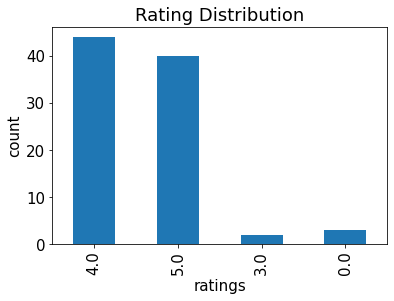

In [ ]:
plt.rc("font",size=15)
ratings['Ratings'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

In [ ]:
##OPTIONAL
count1 = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(count1[count1 >= 0].index)]
count2 = ratings['Ratings'].value_counts()
ratings = ratings[ratings['Ratings'].isin(count2[count2 >= 0].index)]

In [ ]:
##COLLABORATIVE FILTERING USING KNN

ratings.drop(['PostId','Likes','Unnamed: 6'],axis=1,inplace =True)
ratings

,userId,ProductId,Product Name,Ratings
0,eV4OFULtviNcLzZ50jcYbPHsPls2,DHSZCYMHVHSYBCSBZH,boat bassheads 900,4.0
1,h9Rgve39XZOuEgGs2aeHBYIFdfO2,QQGGRFINRXGKLEDRKO,mivi roam,5.0
2,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,PKXVBSZAXRMRHAFOGL,apple iphone xr 64gb,4.0
3,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,OMXHQSAPFYLAKUXOOE,oneplus 7t pro,3.0
4,h9Rgve39XZOuEgGs2aeHBYIFdfO2,HYXJLVUXTPYDNVWLKQ,echo dot 3rd gen,4.0
...,...,...,...,...
84,h9Rgve39XZOuEgGs2aeHBYIFdfO2,VWZLIRRHTRFYCRBDBU,bose quiet comfort 35 ii,4.0
85,QEuXoC2VQVf3uWAj43CtW3Tgvh53,TWGJPMAKNHXIRYWNGK,mivi octave,4.0
86,QEuXoC2VQVf3uWAj43CtW3Tgvh53,IJEKJQHMAWAMUIQWCG,mivi moonstone,4.0
87,QEuXoC2VQVf3uWAj43CtW3Tgvh53,CDIJKEDXHBRDVKGSXJ,portronics roar,4.0


We then group by book titles and create a new column for total rating count.

In [ ]:
ratings = ratings.dropna(axis = 0, subset = ['Product Name'])

product_ratingCount = (ratings.
     groupby(by = ['Product Name'])['Ratings'].
     count().
     reset_index().
     rename(columns = {'Ratings': 'totalRatingCount'})
     [['Product Name', 'totalRatingCount']]
    )
product_ratingCount.head()

,Product Name,totalRatingCount
0,apple iphone 11 64gb white,1
1,apple iphone xr 64gb,1
2,boat bassheads 225,1
3,boat bassheads 510,2
4,boat bassheads 900,1


In [ ]:
rating_with_totalRatingCount = ratings.merge(product_ratingCount, left_on = 'Product Name', right_on = 'Product Name', how = 'left')
rating_with_totalRatingCount.head()

,userId,ProductId,Product Name,Ratings,totalRatingCount
0,eV4OFULtviNcLzZ50jcYbPHsPls2,DHSZCYMHVHSYBCSBZH,boat bassheads 900,4.0,1
1,h9Rgve39XZOuEgGs2aeHBYIFdfO2,QQGGRFINRXGKLEDRKO,mivi roam,5.0,2
2,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,PKXVBSZAXRMRHAFOGL,apple iphone xr 64gb,4.0,1
3,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,OMXHQSAPFYLAKUXOOE,oneplus 7t pro,3.0,1
4,h9Rgve39XZOuEgGs2aeHBYIFdfO2,HYXJLVUXTPYDNVWLKQ,echo dot 3rd gen,4.0,2


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(product_ratingCount['totalRatingCount'].describe())

count   59.000
mean     1.508
std      0.838
min      1.000
25%      1.000
50%      1.000
75%      2.000
max      6.000
Name: totalRatingCount, dtype: float64


The median product has been rated only once. Let’s look at the top of the distribution

In [ ]:
print(product_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900   2.000
0.910   2.000
0.920   2.000
0.930   2.000
0.940   2.520
0.950   3.000
0.960   3.000
0.970   3.000
0.980   3.000
0.990   4.260
Name: totalRatingCount, dtype: float64


In [ ]:
popularity_threshold = 1
rating_popular_product = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_product.head()

,userId,ProductId,Product Name,Ratings,totalRatingCount
0,eV4OFULtviNcLzZ50jcYbPHsPls2,DHSZCYMHVHSYBCSBZH,boat bassheads 900,4.000,1
1,h9Rgve39XZOuEgGs2aeHBYIFdfO2,QQGGRFINRXGKLEDRKO,mivi roam,5.000,2
2,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,PKXVBSZAXRMRHAFOGL,apple iphone xr 64gb,4.000,1
3,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,OMXHQSAPFYLAKUXOOE,oneplus 7t pro,3.000,1
4,h9Rgve39XZOuEgGs2aeHBYIFdfO2,HYXJLVUXTPYDNVWLKQ,echo dot 3rd gen,4.000,2


In [ ]:
rating_popular_product.shape

(89, 5)

**Cosine Similarity

Implementing kNN**

In [ ]:
from scipy.sparse import csr_matrix
rating_popular_product = rating_popular_product.drop_duplicates(['userId', 'Product Name'])
rating_popular_product_pivot = rating_popular_product.pivot(index = 'Product Name', columns = 'userId', values = 'Ratings').fillna(0)
rating_popular_product_matrix = csr_matrix(rating_popular_product_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_popular_product_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
rating_popular_product_pivot

userId,1KRqgTPGQgQq2DbqEuvVLKxXe403,AWeQqaA8UYgx73S7qeqssfrzdHZ2,PafEHeBmb8SYSOprTddeDBbnrGI2,QEuXoC2VQVf3uWAj43CtW3Tgvh53,Re2cQ0UyhXR6ckFCluby85Bq4r52,WYc8FWvDoMhO1NmMuC8EyuK1b6L2,WkkLnRAnQDXosSOkRpIXFJkEELf2,d49QrLhFunX3OkT6qmDOGuix9sY2,eV4OFULtviNcLzZ50jcYbPHsPls2,h8TZtfG4OYT1xROj1kLH6lQ5dTp1,h9Rgve39XZOuEgGs2aeHBYIFdfO2,lYSeURyC2AcaPskg7Jr7Vgi1qN83,rriWmwomOdTWxh3DFcfymLmNhF93,upnSyZKkt8bqCDmxfUyGECK6D0B3
Product Name,,,,,,,,,,,,,,
apple iphone 11 64gb white,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
apple iphone xr 64gb,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
boat bassheads 225,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
boat bassheads 510,0.000,5.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
boat bassheads 900,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000
boat rockerz 255,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000
boat rugby,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000
boat stone 1000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
boat stone 170,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
rating_popular_product_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.]])

In [ ]:
query_index = np.random.choice(rating_popular_product_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(rating_popular_product_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)


5


In [ ]:
rating_popular_product_pivot.index[query_index]

'boat rockerz 255'

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_popular_product_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_popular_product_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for boat rockerz 255:

1: redmi note 8, with distance of 1.0:
2: redmi note 8 pro, with distance of 1.0:
3: portronics pico, with distance of 1.0:
4: samsung galaxy a50 , with distance of 1.0:
5: oppo k3, with distance of 1.0:
